In [1]:
import re
import os
import random as rd
import tensorflow as tf
import matplotlib.pyplot as plt
import pyBigWig as pbg
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.stats
from scipy import sparse

2023-02-14 14:52:00.845449: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 14:52:00.914802: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-14 14:52:00.916882: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-14 14:52:00.916891: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

In [4]:
def ohe(seq):
    seq2=list()
    mapping = {"A":[1, 0, 0, 0], "C": [0, 1, 0, 0], "G": [1, 0, 0, 0], "T":[0, 0, 0, 1]}
    for i in seq:
      seq2.append(mapping[i]  if i in mapping.keys() else [0, 0, 0, 0]) 
    return np.array(seq2)

In [4]:
#fasta to ohe numpy
f=open('/home/florian/projet/r6.16/dmel-all-chromosome-r6.16.fasta','r')
os.chdir('/home/florian/projet/r6.16')
chr_name = str()
seq=[]
D={}
for line in f:
        line = line.rstrip()
        if line[0] == '>':
                if line[1:3]=="2C":
                        break
                if seq != []:
                        D[chr_name]=ohe(seq)
                chr_name = line[1:3].strip()
                seq = []
        else:
                seq += line
D["Y"]=ohe(seq)
np.savez_compressed('seq',**D)

In [35]:
#bigwig to numpy
os.chdir('/home/florian/projet/scATACseq')
fichiers=os.listdir('/home/florian/projet/scATACseq')
valeurs = []
array=np.array(())
for file in fichiers:
    #print("processing file", file)
    bw=pbg.open(file)
    array = np.concatenate((bw.values("2L",0,-1,numpy=True),bw.values("2R",0,-1,numpy=True),bw.values("3R",0,-1,numpy=True),bw.values("3L",0,-1,numpy=True),bw.values("4",0,-1,numpy=True),bw.values("X",0,-1,numpy=True),bw.values("Y",0,-1,numpy=True)))
    if len(valeurs) == 0:
        valeurs = array
    else:
        valeurs += array


In [51]:
#bigwig to numpy v2
os.chdir('/home/florian/projet/scATACseq')
fichiers=os.listdir('/home/florian/projet/scATACseq')
valeurs =[]
chr=["2L","2R","3R","3L","4","X","Y"]
Dic={"2L"}
for file in fichiers:
    #print("processing file", file)
    bw=pbg.open(file)
    array = np.array(())
    for j in chr:
        array=np.append(array,bw.values(j,0,-1,numpy=True))
    if len(valeurs) == 0:
        valeurs = array
    else:
        valeurs += array

In [ ]:
#bigwig to sparse
os.chdir('/home/florian/projet/scATACseq')
fichiers=os.listdir('/home/florian/projet/scATACseq')
values=[]
for file in fichiers:
    bw=pbg.open(file)
    array=np.concatenate((bw.values("4",0,-1,numpy=True),bw.values("X",0,-1,numpy=True),bw.values("Y",0,-1,numpy=True),bw.values("2L",0,-1,numpy=True),bw.values("2R",0,-1,numpy=True),bw.values("3L",0,-1,numpy=True),bw.values("3R",0,-1,numpy=True)))
    values.append(sparse.csr_matrix(array))


In [52]:
os.chdir('/home/florian/projet')
np.savez_compressed('scATACseq',valeurs=valeurs)

In [53]:
#normalization
val=np.copy(np.load('/home/florian/projet/scATACseq.npz')['valeurs'])
val[val >= 2000] = 2000
val=val/2000

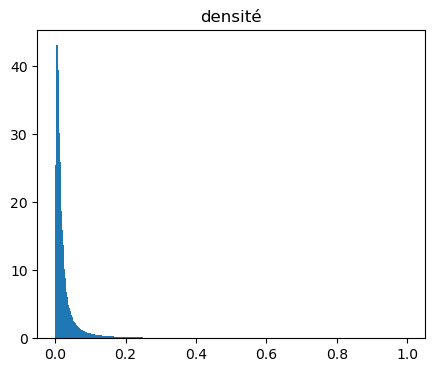

In [73]:
plt.figure(figsize=(5,4))
plt.hist(val,bins=500, density=True)
plt.title("densité")
#plt.xscale('log')
#plt.yscale('log')
plt.show()

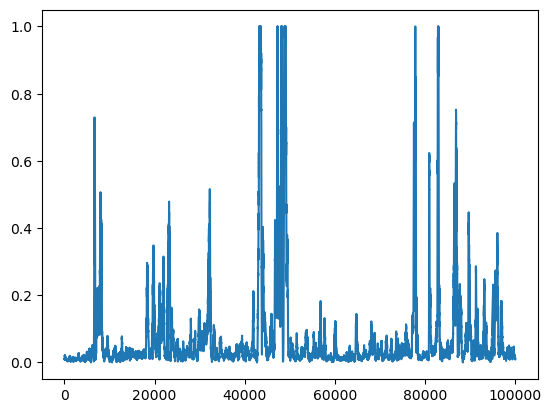

In [21]:
plt.plot((val[1000000:1100000]))

In [ ]:
np.arange(10)[4::-1]

In [3]:
len((np.load('/home/florian/projet/r6.16/seq.npz')['2L']))
#dataset=rd.choices((np.load('/home/florian/projet/r6.16/seq.npz')['2L']),k=100000)
LEN=np.arange(23512712)
dataset=rd.choices(LEN,k=100000)

In [62]:
#create dataset section
Ytrain_chr2L=np.copy(val[1000:10000])
chr2L=np.copy(np.load('/home/florian/projet/r6.16/seq.npz')['2L'])
Xtrain_chr2L=[]
for i in range(1000,10000):
    Xtrain_chr2L.append(chr2L[i-1000:i+1001])
Xtrain_chr2L = np.array(Xtrain_chr2L)


In [36]:
#create dataset random
Ytrain_chr2L=np.copy(val[dataset])
chr2L=np.copy(np.load('/home/florian/projet/r6.16/seq.npz')['2L'])
Xtrain_chr2L=[]
for i in dataset:
    Xtrain_chr2L.append(chr2L[i-1000:i+1001])



In [78]:
#modèle

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(128, kernel_size=(6), activation='relu', input_shape=(2001,4)),
    tf.keras.layers.MaxPooling1D(pool_size=(4)),
    tf.keras.layers.Conv1D(64, kernel_size=(12), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)#, activation="sigmoid")
    ])

loss_fn = tf.keras.losses.MeanSquaredError()

model.compile(loss=loss_fn,
    optimizer='adam',
    metrics=['mae'])

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1996, 128)         3200      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 499, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 488, 64)           98368     
                                                                 
 flatten (Flatten)           (None, 31232)             0         
                                                                 
 dense (Dense)               (None, 128)               3997824   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

In [79]:
history = model.fit(Xtrain_chr2L, Ytrain_chr2L, epochs=3, validation_split=0.30, verbose=1)#, batch_size=128)

Epoch 1/3
197/197 [==============================] - 9s 43ms/step - loss: 0.2382 - mae: 0.1014 - val_loss: 0.0058 - val_mae: 0.0754
Epoch 2/3
197/197 [==============================] - 8s 43ms/step - loss: 0.0098 - mae: 0.0577 - val_loss: 0.0111 - val_mae: 0.0844
Epoch 3/3
197/197 [==============================] - 9s 44ms/step - loss: 0.0027 - mae: 0.0365 - val_loss: 0.0156 - val_mae: 0.1004


In [19]:
len(Xtrain_chr2L)==len(Ytrain_chr2L)

True

In [22]:
len((np.load('/home/florian/projet/r6.16/seq.npz')['2L']))+len(np.load('/home/florian/projet/r6.16/seq.npz')['2R'])+len(np.load('/home/florian/projet/r6.16/seq.npz')['3R'])+len(np.load('/home/florian/projet/r6.16/seq.npz')['3L'])+len(np.load('/home/florian/projet/r6.16/seq.npz')['4'])+len(np.load('/home/florian/projet/r6.16/seq.npz')['X'])+len(np.load('/home/florian/projet/r6.16/seq.npz')['Y'])

137547960

9/9 [==============================] - 2s 223ms/step


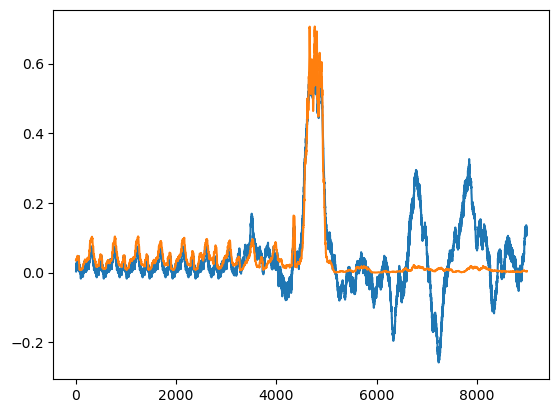

In [80]:
#prediction plot
pred=model.predict(Xtrain_chr2L, batch_size=1024)
plt.plot(pred)
plt.plot(Ytrain_chr2L)

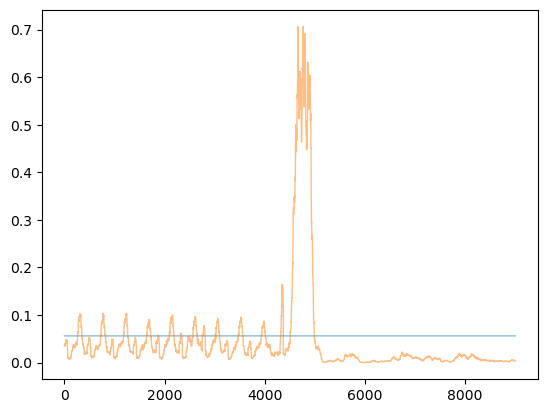

In [58]:
plt.plot(pred, alpha=0.5, linewidth=1)
plt.plot(Ytrain_chr2L, alpha=0.5, linewidth=1)

In [43]:
np.shape(Xtrain_chr2L[0])

(2001, 4)

In [103]:
model.predict(np.concatenate((np.zeros((1, 2001, 3)), np.ones((1, 2001, 1))), axis=-1))

1/1 [==============================] - 0s 12ms/step


array([[0.01433587]], dtype=float32)

In [102]:
np.concatenate((np.zeros((1, 2001, 3)), np.ones((1, 2001, 1))), axis=-1).shape

(1, 2001, 4)